## Predicting Customer Churn 

##### A short notebook experimenting with the IBM Customer Churn Dataset

<ul>
    <li><a href="#imports">Imports</li>
    <li><a href="#investigate">Investigating the data</li>
    <li><a href="#ttest">T-tests and statistical difference</li>
    <li><a href="#visualize">Visualizing the data</li>
    <li><a href="#model">Modelling</li>
    <ul>
        <li><a href="#logistic">Logistic Regression</li>
        <li><a href="#forest">Random Forest Classifier</li>
        <li><a href="#boost">Gradient Boosting Classifier with Gridsearch</li>
    </ul>
    <li><a href="#final">Final Notes</li>

</ul>

<a id="imports"></a>
### Imports 

In [123]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
pd.set_option('max_columns', None)
sns.set_style('white')


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import GridSearchCV

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<a id="investigate"></a>
### Investigating the data 

In [61]:
ibm = pd.read_csv('data/IBM_churn.csv')

In [62]:
ibm.shape
#7043 rows of data with 21 columns

(7043, 21)

In [63]:
# Ensuring that each entry is unique 
print(len(ibm.customerID.unique()))
print(ibm.shape[0])

7043
7043


In [64]:
ibm.info()
# A lot of string / object encoding to be sorted out 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [65]:
#looking at the first ten lines of data 
ibm.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [66]:
#creating a function to turn any objects / strings to floats

def to_numeric(x):
    try:
        return float(x)
    except: 
        return np.nan

In [67]:
ibm.TotalCharges = ibm.TotalCharges.map(to_numeric)

In [68]:
ibm.TotalCharges.isna().sum() 

11

In [69]:
# 11 NULL entries - I wonder why? 
# This should be investigated  further - possibly they have not yet paid a first bill? 
# For now however I'll drop them from the data 
ibm[ibm.TotalCharges.isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [70]:
ibm.drop(index=ibm[ibm.TotalCharges.isna()].index, inplace=True)

In [71]:
# Defining a function to turn Yes, No -> 1, 0
# Had initially returned np.nan if it was not encoded as Yes or No, 
# But on further investigation decided that other encodings would also work as zero 
def make_binary(x): 
    if x == 'Yes': 
        return 1
    else:
        return 0

In [72]:
ibm.Partner = ibm.Partner.map(make_binary)
ibm.Dependents = ibm.Dependents.map(make_binary)
ibm.PhoneService = ibm.PhoneService.map(make_binary)
ibm.MultipleLines = ibm.MultipleLines.map(make_binary)
ibm.PaperlessBilling = ibm.PaperlessBilling.map(make_binary)
ibm.Churn = ibm.Churn.map(make_binary)

ibm.loc[:, 'OnlineSecurity':'StreamingMovies'] = \
        ibm.loc[:, 'OnlineSecurity':'StreamingMovies'].applymap(make_binary)  

In [73]:
#and I'll go ahead and drop the unique customer index, as it doesn't add any info 
ibm.drop(columns='customerID', inplace=True)

In [74]:
ibm.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [75]:
print('Possible values for InternetService:', ibm.InternetService.unique())
print('Possible values for Contract:', ibm.Contract.unique())
print('Possible values for PaymentMethod:', ibm.PaymentMethod.unique())

Possible values for InternetService: ['DSL' 'Fiber optic' 'No']
Possible values for Contract: ['Month-to-month' 'One year' 'Two year']
Possible values for PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [76]:
# Reassigning values for the payment method to make them easier to read

ibm.PaymentMethod = ibm.PaymentMethod.map(lambda x: {'Electronic check': 'e-check', 
                                'Mailed check': 'mailed-check', 
                                'Bank transfer (automatic)': 'bank-transfer', 
                                'Credit card (automatic)': 'credit-card'}.get(x, np.nan))


In [77]:
#creating dummies for the rest of the object columns: 
ibm = pd.get_dummies(ibm, 
                columns=['gender', 'InternetService', 'Contract', 'PaymentMethod'], 
                drop_first=True)

In [78]:
ibm.head(2)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_credit-card,PaymentMethod_e-check,PaymentMethod_mailed-check
0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,0,1,0
1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,1,0,0,0,1


In [79]:
# Ensuring that everything bar the customer ID is now numeric data 
ibm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
SeniorCitizen                  7032 non-null int64
Partner                        7032 non-null int64
Dependents                     7032 non-null int64
tenure                         7032 non-null int64
PhoneService                   7032 non-null int64
MultipleLines                  7032 non-null int64
OnlineSecurity                 7032 non-null int64
OnlineBackup                   7032 non-null int64
DeviceProtection               7032 non-null int64
TechSupport                    7032 non-null int64
StreamingTV                    7032 non-null int64
StreamingMovies                7032 non-null int64
PaperlessBilling               7032 non-null int64
MonthlyCharges                 7032 non-null float64
TotalCharges                   7032 non-null float64
Churn                          7032 non-null int64
gender_Male                    7032 non-null uint8
InternetService_Fiber 

In [80]:
#and confirming no null values
ibm.isna().sum()

SeniorCitizen                  0
Partner                        0
Dependents                     0
tenure                         0
PhoneService                   0
MultipleLines                  0
OnlineSecurity                 0
OnlineBackup                   0
DeviceProtection               0
TechSupport                    0
StreamingTV                    0
StreamingMovies                0
PaperlessBilling               0
MonthlyCharges                 0
TotalCharges                   0
Churn                          0
gender_Male                    0
InternetService_Fiber optic    0
InternetService_No             0
Contract_One year              0
Contract_Two year              0
PaymentMethod_credit-card      0
PaymentMethod_e-check          0
PaymentMethod_mailed-check     0
dtype: int64

In [81]:
#moving 'Churn' to the end for the heatmap
new_list = list(ibm.columns.copy())

new_list.remove('Churn')
new_list.append('Churn')

ibm.columns = new_list

Percentage of customer churn:  0.22810011376564276
Baseline =  0.7718998862343572


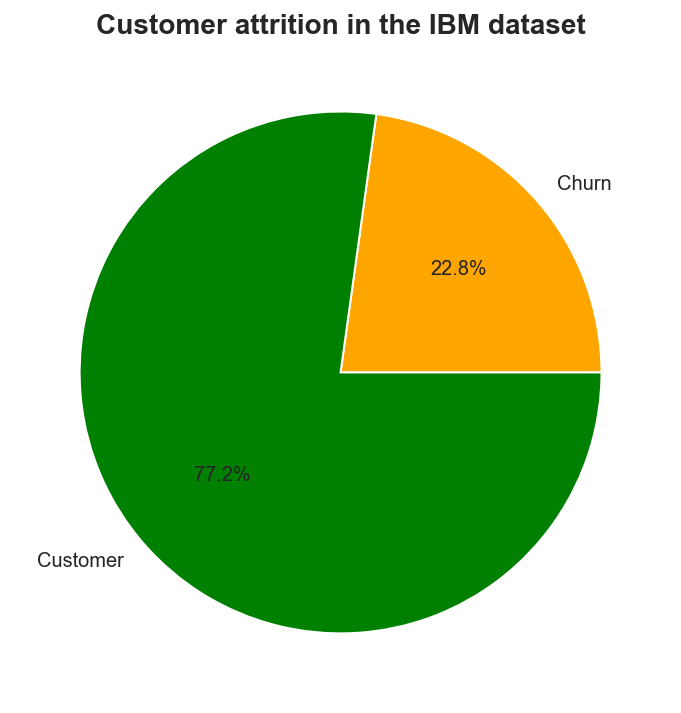

In [82]:
#So - how many Customers in my data have churned? 

print('Percentage of customer churn: ', ibm.Churn.mean())
print('Baseline = ', (1-ibm.Churn.mean()))

# and let's visualize this 
fig, ax = plt.subplots(figsize=(6,6))

plt.pie([ibm.Churn.mean(),(1-ibm.Churn.mean())], 
        autopct='%1.1f%%',
        labels=['Churn', 'Customer'], 
        colors=['orange', 'green'])
plt.title('Customer attrition in the IBM dataset', fontweight='bold', fontsize=14)

plt.savefig('images/churn_pie.png', dpi=200)
plt.show()

In [83]:
# Grouping by Churn to see various summary statistics - will pull out a few of interest, 
# as these statistics seem to be fairly different in the groups 

ibm.groupby('Churn').describe()

SeniorCitizen                                              Partner  \
              count      mean       std  min  25%  50%  75%  max   count   
Churn                                                                      
0            5428.0  0.193073  0.394746  0.0  0.0  0.0  0.0  1.0  5428.0   
1            1604.0  0.058603  0.234954  0.0  0.0  0.0  0.0  1.0  1604.0   

                                                   Dependents            \
           mean       std  min  25%  50%  75%  max      count      mean   
Churn                                                                     
0      0.508843  0.499968  0.0  0.0  1.0  1.0  1.0     5428.0  0.284451   
1      0.393392  0.488655  0.0  0.0  0.0  1.0  1.0     1604.0  0.346010   

                                          tenure                             \
            std  min  25%  50%  75%  max   count       mean        std  min   
Churn                                                                         
0      0.451194  0.0  0.0  0.0  1.0  1.0  5428.0  35.519528  24.607256  1.0   
1      0.475845  0.0  0.0  0.0  1.0  1.0  1604.0  21.938903  21.214997  1.0   

                              PhoneService                                     \
        25%   50%   75%   max        count      mean       std  min  25%  50%   
Churn                                                                           
0      12.0  35.0  59.0  72.0       5428.0  0.904016  0.294596  0.0  1.0  1.0   
1       3.0  15.0  36.0  72.0       1604.0  0.900873  0.298926  0.0  1.0  1.0   

                MultipleLines                                               \
       75%  max         count      mean       std  min  25%  50%  75%  max   
Churn                                                                        
0      1.0  1.0        5428.0  0.483051  0.499759  0.0  0.0  0.0  1.0  1.0   
1      1.0  1.0        1604.0  0.215087  0.411011  0.0  0.0  0.0  0.0  1.0   

      OnlineSecurity                                               \
               count      mean       std  min  25%  50%  75%  max   
Churn                                                               
0             5428.0  0.306190  0.460952  0.0  0.0  0.0  1.0  1.0   
1             1604.0  0.220075  0.414426  0.0  0.0  0.0  0.0  1.0   

      OnlineBackup                                               \
             count      mean       std  min  25%  50%  75%  max   
Churn                                                             
0           5428.0  0.389831  0.487757  0.0  0.0  0.0  1.0  1.0   
1           1604.0  0.192643  0.394498  0.0  0.0  0.0  0.0  1.0   

      DeviceProtection                                               \
                 count      mean       std  min  25%  50%  75%  max   
Churn                                                                 
0               5428.0  0.392225  0.488291  0.0  0.0  0.0  1.0  1.0   
1               1604.0  0.180175  0.384453  0.0  0.0  0.0  0.0  1.0   

      TechSupport                                              StreamingTV  \
            count      mean       std  min  25%  50%  75%  max       count   
Churn                                                                        
0          5428.0  0.310980  0.462937  0.0  0.0  0.0  1.0  1.0      5428.0   
1          1604.0  0.219451  0.414004  0.0  0.0  0.0  0.0  1.0      1604.0   

                                                   StreamingMovies            \
           mean       std  min  25%  50%  75%  max           count      mean   
Churn                                                                          
0      0.449889  0.497528  0.0  0.0  0.0  1.0  1.0          5428.0  0.454679   
1      0.162718  0.369223  0.0  0.0  0.0  0.0  1.0          1604.0  0.163965   

                                         PaperlessBilling                      \
            std  min  25%  50%  75%  max            count      mean       std   
Churn                                                           

In [84]:
print('SeniorCitizen mean across the whole dataset: ', ibm.SeniorCitizen.mean())
print('SeniorCitizen statistics grouped by churn: ')
ibm.groupby('Churn').SeniorCitizen.agg(['count', 'mean'])

SeniorCitizen mean across the whole dataset:  0.16240045506257111
SeniorCitizen statistics grouped by churn: 


,count,mean
Churn,,
0,5428,0.193073
1,1604,0.058603


In [85]:
print('Partner statistics grouped by churn: ')
ibm.groupby('Churn').Partner.agg(['count', 'mean'])

Partner statistics grouped by churn: 


,count,mean
Churn,,
0,5428,0.508843
1,1604,0.393392


In [86]:
print('Percentage male across the whole dataset: ', ibm.gender_Male.mean())
print('Percentage male in customer and churned customer groups: ')
ibm.groupby('Churn')['gender_Male'].mean()

Percentage male across the whole dataset:  0.26578498293515357
Percentage male in customer and churned customer groups: 


Churn
0    0.287583
1    0.192020
Name: gender_Male, dtype: float64

<a id="ttest"></a>
### T-tests and statistical difference 

**But are there actually statistical differences between these groups?**

When comparing differences between groups, the t-statistic is the go-to 
metric to help us understand whether these differences are meaningful or by chance. In essence our t-statistic will be a standardized version of the difference between groups, where the standardization is adjusting for the variance in measurements.

We can use the inbuilt scipy.stats method to help us, and we'll be particularly interested in the p-value. 

The p-value is the probability that, given the null hypothesis (**H0** - there is no statistical difference between the two groups) is true, we could have ended up with a statistic at least as extreme as the one measured. If the pvalue is suitably small, we can reject this and accept the alternate (**H1** - the two groups are statistically different). 

In [87]:
#let's test one the groups we looked at above, our gender statistics 

male_churn = ibm.Churn[ibm.gender_Male==1]
female_churn = ibm.Churn[ibm.gender_Male==0]

t_test_gender = stats.ttest_ind(male_churn, female_churn)
print(t_test_gender)

Ttest_indResult(statistic=-7.642408646124134, pvalue=2.4152160057918116e-14)


The p-value  is small enough to indicate that there are indeed significant differences in the groups. 

There is a higher percentage of males in our no-churn group than in our churn group. This is an interesting insight for both product and marketing teams, and could influence how they try to reach out to their customers. 



<a id="visualize"></a>
### Visualizing the data

In [88]:
# Now let's look at some further visualisations 

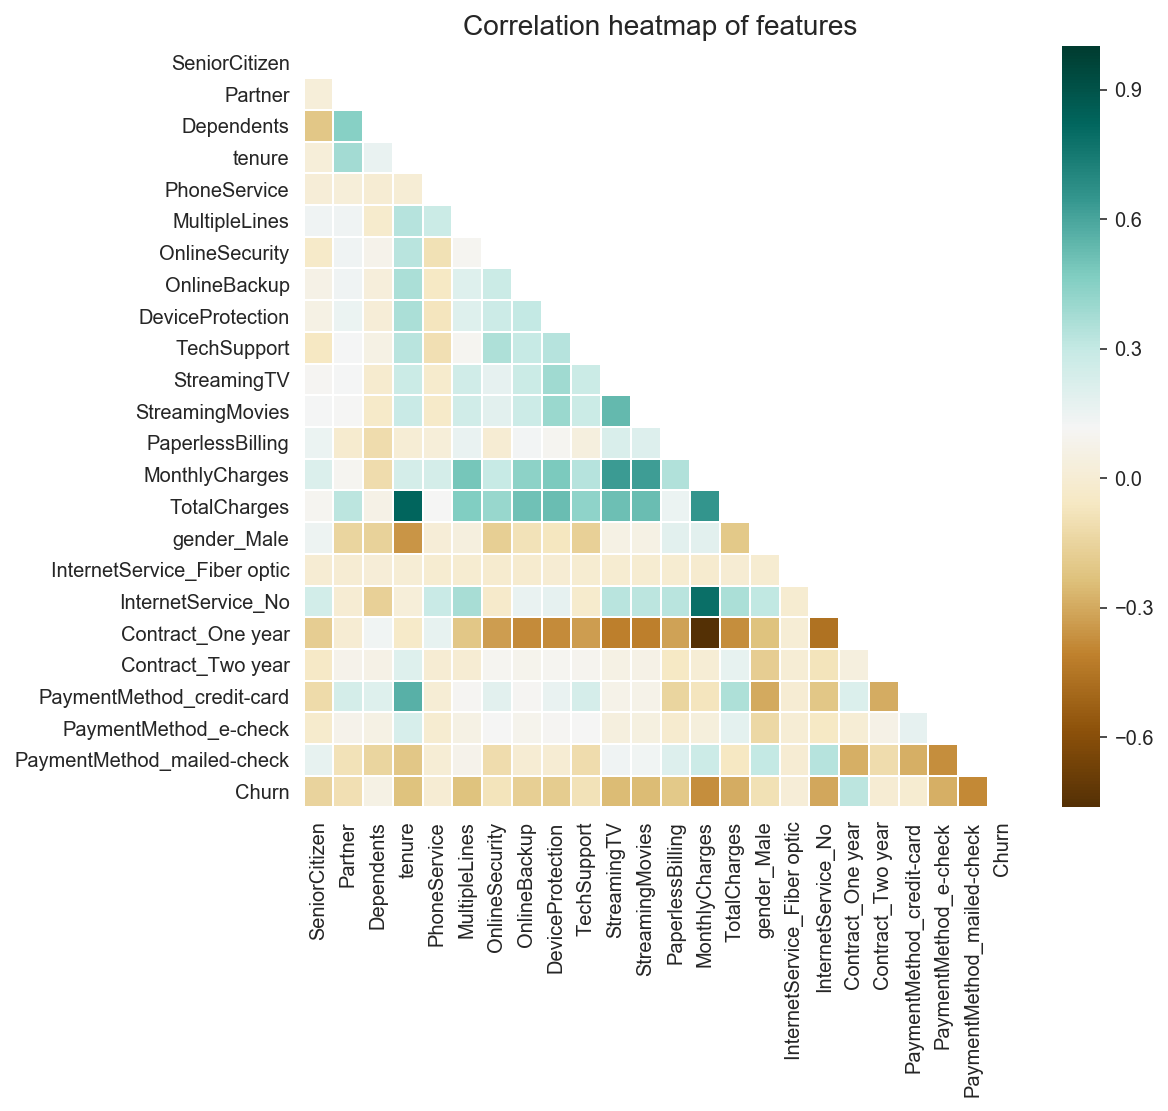

In [94]:
fig, ax = plt.subplots(figsize=(8,7))

mask = np.zeros_like(ibm.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(ibm.corr(), linewidth=0.5, mask=mask, cmap="BrBG" )

plt.title('Correlation heatmap of features', fontsize=14)
plt.show()

There are some strong correlations between input / independent variables ('TotalCharges' and 'tenure', 'InternetService_No' and 'MonthlyCharges'). Variables most strongly correlated to 'Churn' are 'MonthlyCharges', and 'PaymentMethod_mailed-check'. 

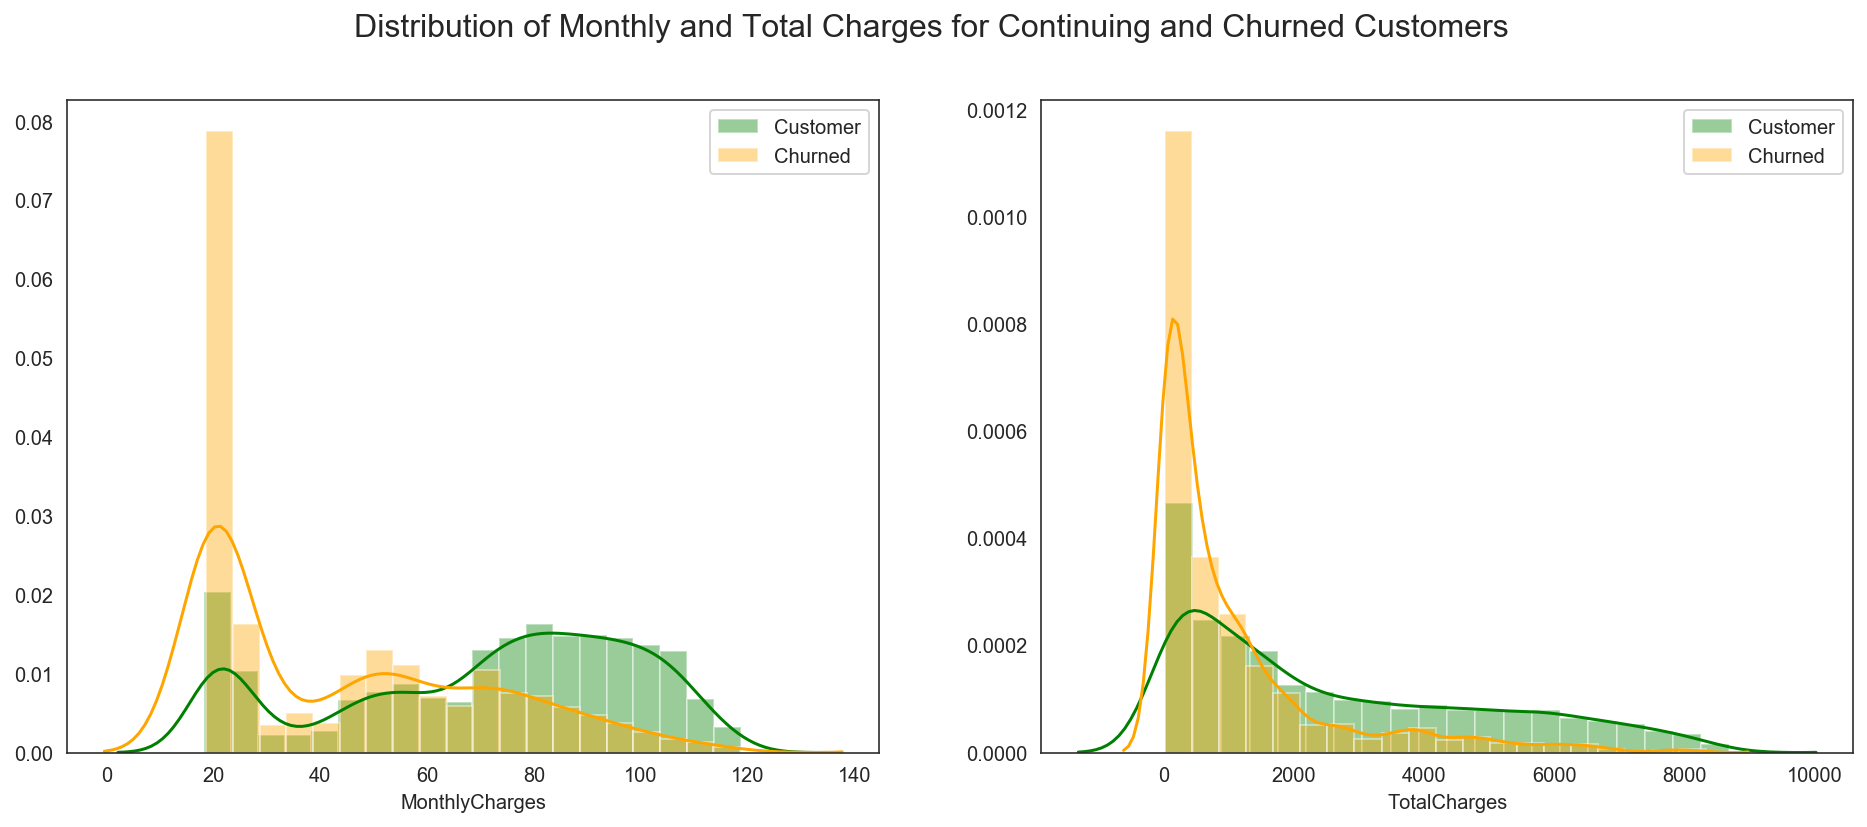

In [90]:
# Let's look at some distributions between the groups. 
#Unsurprisingly, we see peaks at the lower end of charges for our churned customers. 

fig, ax = plt.subplots(ncols = 2, figsize=(16, 6))
sns.distplot(ibm.MonthlyCharges[ibm.Churn == 0], color='green', label = 'Customer', ax = ax[0], bins=20)
sns.distplot(ibm.MonthlyCharges[ibm.Churn == 1], color='orange', label = 'Churned', ax = ax[0], bins=20)
ax[0].legend()

sns.distplot(ibm.TotalCharges[ibm.Churn == 0], color='green', label = 'Customer', ax = ax[1], bins=20)
sns.distplot(ibm.TotalCharges[ibm.Churn == 1], color='orange', label = 'Churned', ax = ax[1], bins=20)
ax[1].legend()


plt.suptitle('Distribution of Monthly and Total Charges for Continuing and Churned Customers', fontsize=16)
plt.show()

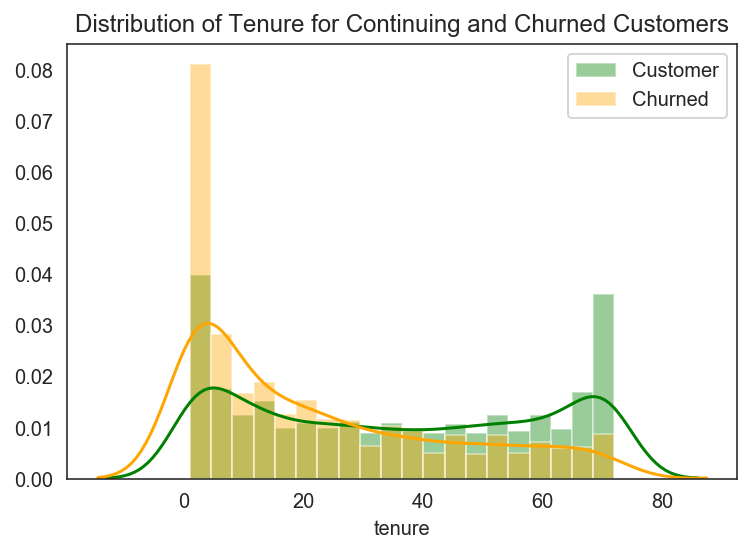

In [95]:
sns.distplot(ibm.tenure[ibm.Churn == 0], color='green', label = 'Customer', bins=20)
sns.distplot(ibm.tenure[ibm.Churn == 1], color='orange', label = 'Churned', bins=20)
plt.title('Distribution of Tenure for Continuing and Churned Customers')
plt.legend();

In [96]:
#I'll drop the tenure info prior to modelling, as knowing how long a customer has 
#been with you is analagous to whether or not they have churned. 

In [97]:
rubbish = ibm.pop('tenure')

In [98]:
#and I'll set up a scoring function: 

def score_model(model, X_train, y_train, X_test, y_test): 
    print('Training score: ', model.score(X_train, y_train))
    print('Test score: ', model.score(X_test, y_test))
    print('Cross-val-score: ', cross_val_score(model, X_train, y_train, cv=5).mean())

In [99]:
#setting up my X and y variables
y = ibm.pop('Churn')
X = ibm

#split into train + test groups 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

#standardize the data prior to modelling
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

<a id="model"></a>

### Modelling 

<a id="logistic"></a>

#### Logistic Regression

In [117]:
#instantiate my first model 
logreg = LogisticRegressionCV(n_jobs=2, cv=5)

In [118]:
logreg.fit(X_train_std, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=2, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [119]:
logreg.C_[0]

0.046415888336127774

In [120]:
score_model(logreg, X_train_std, y_train , X_test_std, y_test)

Training score:  0.8780444444444444
Test score:  0.8784648187633263
Cross-val-score:  0.8728892841616294


In [126]:
#so it's performing a better than baseline - but let's see where it's going wrong 
#by means of a confusion matrix. 
# I'll also pull out the recall score from the perspective of class 1. 

logreg_predict = logreg.predict(X_test_std)

print('Recall score on test data: ', recall_score(y_test, logreg_predict))

pd.DataFrame(confusion_matrix(y_test, logreg_predict, labels=[0,1]), 
             columns=['Pred_0', 'Pred_1'], index=['True_0', 'True_1'])

Recall score on test data:  0.7694704049844237


,Pred_0,Pred_1
True_0,989,97
True_1,74,247


In [104]:
coefs = pd.DataFrame(list(zip(X.columns, logreg.coef_[0])), 
            columns=['Feature', 'Coefficient']).sort_values(by=('Coefficient'))

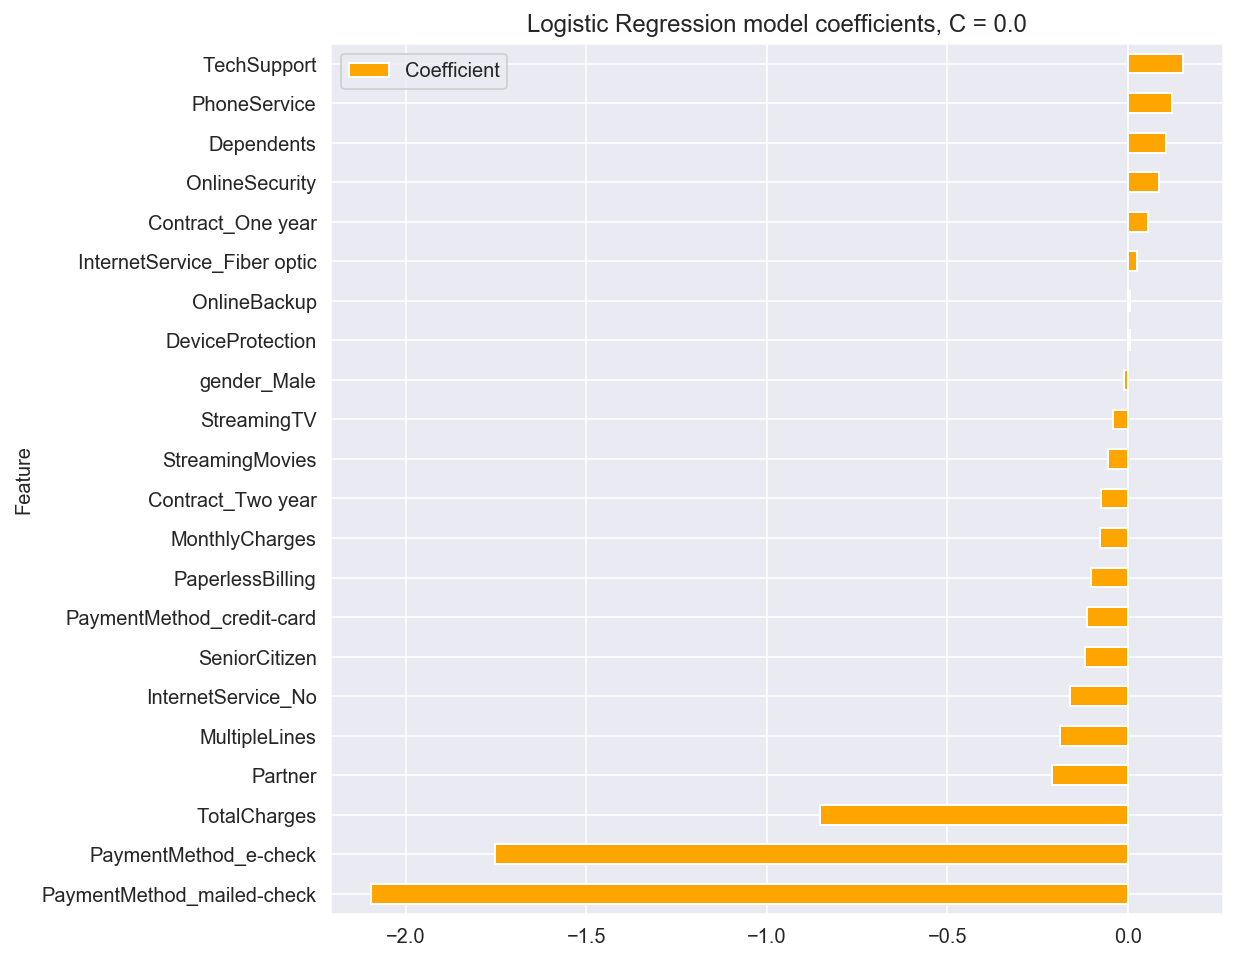

In [105]:
sns.set_style('darkgrid')
coefs.plot(kind='barh',x='Feature', y='Coefficient', figsize=(8, 8), color='orange')
plt.title('Logistic Regression model coefficients, C = {}'.format(np.round(logreg.C_[0]), 2))
plt.show()

**Notes on the coefficients:** the three coefficients contributing most strongly to predicting class 0 (i.e. No Churn), are PaymentMethod_mailed-check, PaymentMethod_e-check, and TotalCharges. 

With the Payment Method variables, it's important to bear in mind that these are in relationship to the variable dropped when we called get_dummies(), which was PaymentMethod = Bank Transfer. 

This could possibly be related to the fact that checks are a more old-fashioned way of making payment, and older customers are less likely to switch telecoms providers. 

TotalCharges is proportional to how long a customer has been with a company, this is another variable that we could consider dropping from the input data as it is self-fulfilling (i.e. customers who have stayed haven't left). 


In [53]:
# Let's see if we can improve model accuracy. We'll try a RandomForestClassifier: 

<a id="forest"></a>

#### Random Forest Classifier 

In [106]:
model_rf = RandomForestClassifier(n_estimators=500)
model_rf.fit(X_train_std, y_train)

score_model(model_rf, X_train_std, y_train, X_test_std, y_test)

Training score:  0.9992888888888889
Test score:  0.8727789623312011
Cross-val-score:  0.8712922859308048


In [ ]:
# The Random Forest hasn't improved our accuracy, what about a GradientBoostingClassifier 
# with Gridsearch? 

<a id="boost"></a>

#### Gradient Boosting Classifier with Gridsearch 

In [110]:
model_boost = GradientBoostingClassifier()

params = {'n_estimators': [500], 
          'max_depth': [2,3,4], 
         'max_features': [0.7, 0.8, 0.9]}

model_gs = GridSearchCV(model_boost, params, cv=5, verbose=1)
model_gs.fit(X_train_std, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [111]:
model_gs.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=0.9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [112]:
model_gs.best_score_

0.8736

In [113]:
model_boost = GradientBoostingClassifier(max_depth=2, max_features=0.7, n_estimators=1000)
model_boost.fit(X_train_std, y_train)

score_model(model_boost, X_train_std, y_train, X_test_std, y_test)

Training score:  0.9244444444444444
Test score:  0.8692253020611229
Cross-val-score:  0.8691554746468496


In [127]:
# Still not improving more than about 10% from baseline. 
# Let's look at the confusion matrix to see if there is a similar spread of errors. 

boost_predict = model_boost.predict(X_test_std)

print('Recall score on test data: ', recall_score(y_test, boost_predict))

pd.DataFrame(confusion_matrix(y_test, boost_predict, labels=[0,1]), 
             columns=['Pred_0', 'Pred_1'], index=['True_0', 'True_1'])

Recall score on test data:  0.6728971962616822


,Pred_0,Pred_1
True_0,1007,79
True_1,105,216


<a id="final"></a>

#### Final Notes 

While the Gradient Boosting Classifier does a better job at predicting Class 0 compared to the Logistic Regression, it's probably class 1 (Customers who churn) that we are more interested in predicting. From this perspective, the original Logistic Regression, with it's higher Recall score, will be the model of choice. It also gives us clear coefficients, helping to explain how our data influences the predictions.   

It seems quite hard to improve our accuracy beyond 87%, but given a baseline of 77% I am still happy with this. To illustrate why it might be so hard for the models to distinguish between 'churn' and 'no churn' customers, I am going to visualize the customers in two dimensions, to show how much overlap there is between our two groups. 

In the below scatterplot, showing our customers in two dimensions, I have distinguished between the true churn / no churn customers (by colour) and the predicted churn / no churn customers (by shape). 

Obviously showing 2-dimensions only gives us part of the picture, but the clear overlap between groups helps to explain the difficulties of improving the accuracy above 87%. 

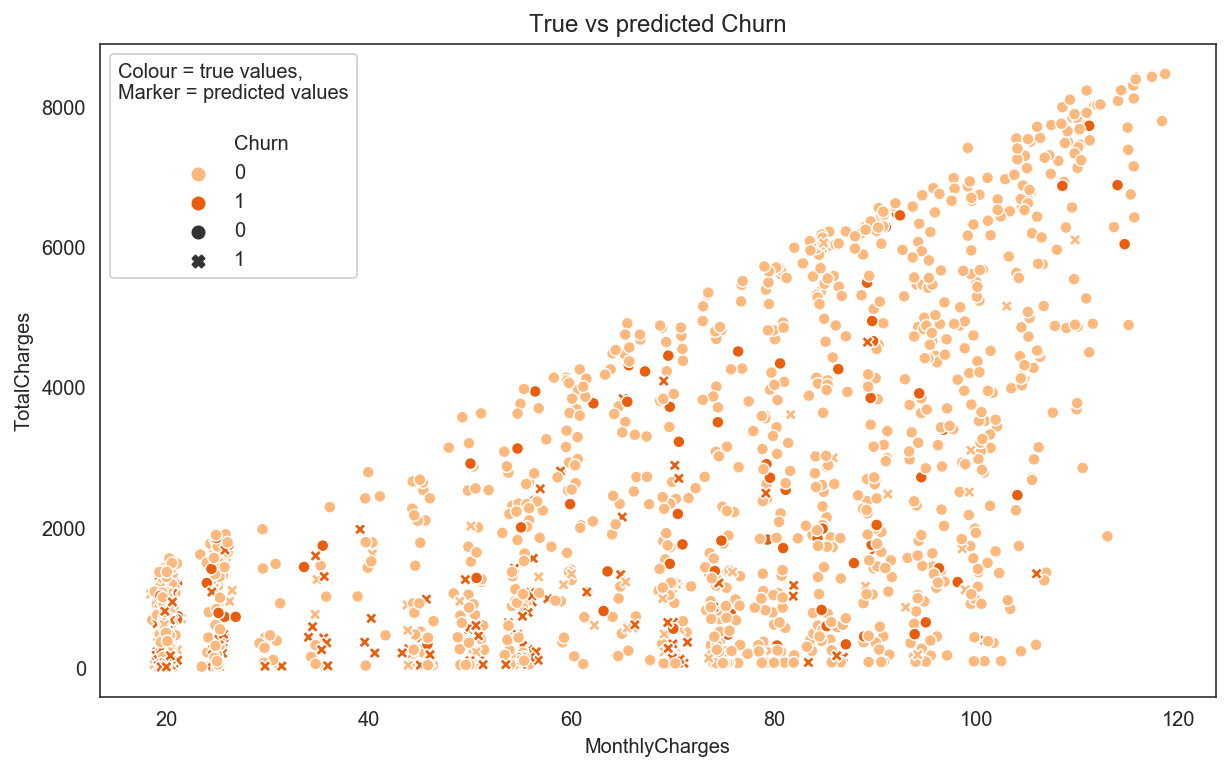

In [115]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(X_test['MonthlyCharges'], X_test['TotalCharges'], 
            hue=y_test, style=boost_predict, palette='Oranges')


ax.legend(title='Colour = true values, \nMarker = predicted values\n')
plt.title('True vs predicted Churn')
plt.show()